Found 301 images belonging to 2 classes.
Found 150 images belonging to 2 classes.
Found 52 images belonging to 2 classes.


Epoch 1/3
5/5 [==============================] - ETA: 0s - loss: 0.4873 - accuracy: 0.7407WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 10 batches). You may need to use the repeat() function when building your dataset.


5/5 [==============================] - 3s 438ms/step - loss: 0.4873 - accuracy: 0.7407 - val_loss: 0.1142 - val_accuracy: 0.9667
Epoch 2/3
5/5 [==============================] - 1s 126ms/step - loss: 0.2125 - accuracy: 0.9200
Epoch 3/3
3/3 [==============================] - 0s 74ms/step - loss: 0.0620 - accuracy: 0.9808
Accuracy: 0.9807692170143127
1/1 [==============================] - 0s 25ms/step
10 10 10


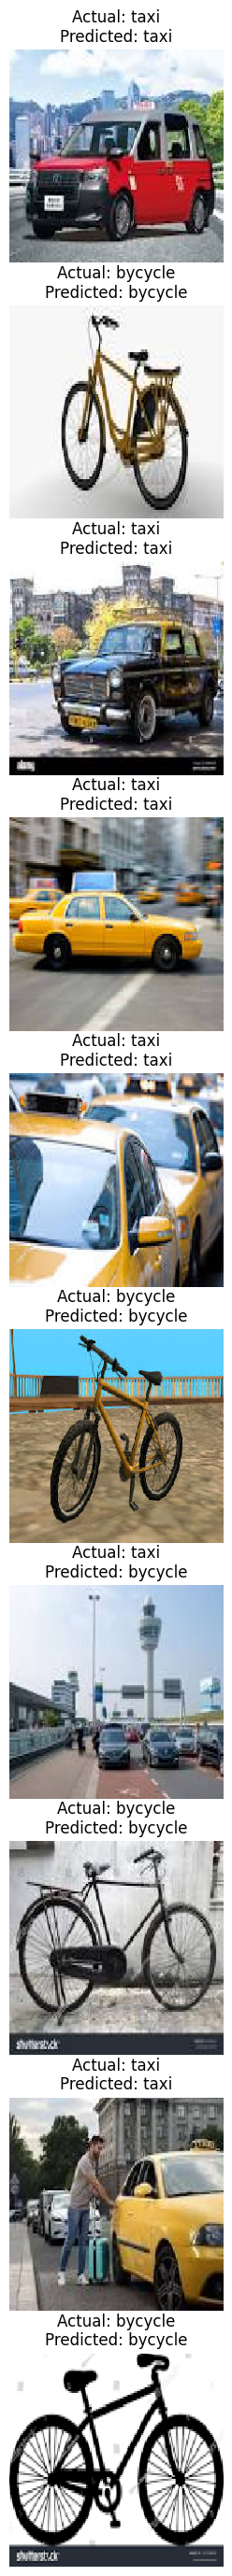

In [5]:
import tensorflow as tf
import numpy as np
import os
import zipfile
import shutil
from random import shuffle

from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras import applications

import matplotlib.pyplot as plt


    
# Датасеты разделены на 60:30:10 (train:validation:test)
test_images_path =  '/Users/lerfich/Documents/lab4/Car/test'
train_images_path = '/Users/lerfich/Documents/lab4/Car/train'
validation_images_path = '/Users/lerfich/Documents/lab4/Car/validation'
local_path = '/Users/lerfich/Documents/lab4/Car'

generator_train = image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')


def create_dataset():
    train_data = generator_train.flow_from_directory(
        train_images_path,
        target_size=(224, 224),
        batch_size=20,
        class_mode='binary')

    validation_data = image.ImageDataGenerator(rescale=1./255).flow_from_directory(
        validation_images_path,
        target_size=(224, 224),
        batch_size=20,
        class_mode='binary')

    test_data = image.ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_images_path,
        target_size=(224, 224),
        batch_size=20,
        class_mode='binary')

    return [train_data, validation_data, test_data]    

def create_model():
    model = applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    model.trainable = False
    x = Dense(1024, activation='relu')(GlobalAveragePooling2D()(model.output))
    results = Dense(1, activation='sigmoid')(x)

    return [results, x, model]


def fit_model():
    [train_data, validation_data, test_data] = create_dataset()
    [results, x, model] = create_model()

    LEARNING_RATE_MODEL = 0.0005

    model = Model(inputs=model.input, outputs=results)
    model.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE_MODEL), loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(
        train_data,
        steps_per_epoch=5,
        epochs=3,
        validation_data=validation_data,
        validation_steps=10)

    _, accuracy = model.evaluate(test_data)
    print(f"Accuracy: {accuracy}")
    return model


def show_comparison(model):
    TEST_BATCH_SIZE = 10
    test_images = []
    labels = []
    model_predictions = []

    for j in range(TEST_BATCH_SIZE):
        batch = next(test_data)
        for i in range(batch[0].shape[0]):
            predicted_img = batch[0][i]
            real_img = batch[1][i]


            pred = model.predict(np.expand_dims(predicted_img, axis=0))
            pred_label = "taxi" if pred[0][0] > 0.5 else "bycycle"

            test_images.append(predicted_img)
            labels.append("taxi" if real_img == 1 else "bycycle")
            model_predictions.append(pred_label)

            if len(test_images) >= TEST_BATCH_SIZE:
                break
        if len(test_images) >= TEST_BATCH_SIZE:
            break

    plt.figure(figsize=(15, 35))
    for i in range(len(test_images)):
        plt.subplot(TEST_BATCH_SIZE, 1, i + 1)
        image = (test_images[i] * 255).astype(np.uint8)
        plt.imshow(image)
        plt.title(f"Actual: {labels[i]}\nPredicted: {model_predictions[i]}")
        plt.axis("off")    

    print(len(test_images), len(labels), len(model_predictions))

model = fit_model()
show_comparison(model)    


